# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
from sklearn.model_selection import train_test_split

import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms as T
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable

import numbers
from PIL import Image, ImageOps
import math
import zipfile
import matplotlib.image as mpimg
from collections import defaultdict
import time
from tqdm.notebook import tqdm
import albumentations as A #great data augmentation lib
import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
! pip install torchsummary
from torchsummary import summary
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 42 kB 516 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 2.7 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=171c662b1adfc13ec3eb23efa62b0b59d382984819bee840efaa4ac06caec972
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=ba0a9910a03b93b395865ac2e8d9799ed1c82c89894a0f992665dfb4e78f7a59
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch


# Input Data

In [3]:
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/train.zip") as z:
    z.extractall("./train/")
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/test.zip") as z:
    z.extractall("./test/")
# ! unzip "/kaggle/input/tgs-salt-identification-challenge/train.zip" -d './train/'
# ! unzip "/kaggle/input/tgs-salt-identification-challenge/test.zip" -d './test/'
print('unzip finished')

unzip finished


In [4]:
TRAIN_CSV = '/kaggle/input/tgs-salt-identification-challenge/train.csv'
DEPTH_CSV = '/kaggle/input/tgs-salt-identification-challenge/depths.csv'

TRAIN_IMAGE_DIR = '/kaggle/working/train/images/'
TRAIN_MASK_DIR = '/kaggle/working/train/masks/'

TEST_IMAGE_DIR = '/kaggle/working/test/images/'

In [5]:
df_train = pd.read_csv(TRAIN_CSV)
df_depth = pd.read_csv(DEPTH_CSV)

df = pd.merge(df_depth, df_train)
df['salt'] = df['rle_mask'].notnull().replace([False, True], [0,1]) #0 = no_salt #1 = salt

df.head()

,id,z,rle_mask,salt
0,4ac19fb269,306,5757 1 5851 8 5936 24 6034 27 6134 28 6224 39 ...,1
1,1825fadf99,157,NaN,0
2,f59821d067,305,36 66 137 66 239 65 340 65 442 64 543 64 644 6...,1
3,5b435fad9d,503,7474 1 7574 2 7674 3 7774 4 7874 5 7974 6 8074...,1
4,e340e7bfca,783,NaN,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4000 non-null   object
 1   z         4000 non-null   int64 
 2   rle_mask  2438 non-null   object
 3   salt      4000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 156.2+ KB


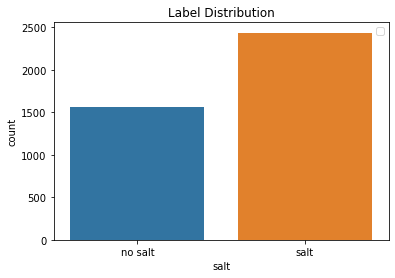

In [7]:
no_salt = df[df['rle_mask'].isnull()]
salt = df[df['rle_mask'].notnull()]

# dist = (len(no_salt), len(salt))
# plt.bar([0,1], dist, color=['g', 'b'])
sns.countplot(df['salt'])
plt.xticks(ticks= [0,1], labels=['no salt', 'salt'])
plt.title('Label Distribution'); plt.ylabel('count')
plt.legend();

In [8]:
len(no_salt), len(salt)

(1562, 2438)

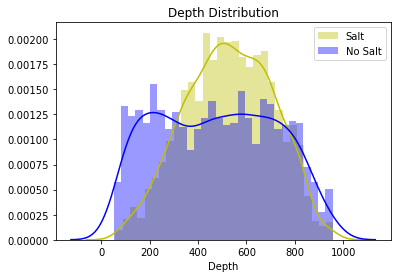

In [9]:
sns.distplot(salt['z'], label='Salt', bins=30, color='y')
sns.distplot(no_salt['z'], label='No Salt', bins=30, color='b')
plt.title('Depth Distribution')
plt.xlabel('Depth'); plt.legend()
plt.show()

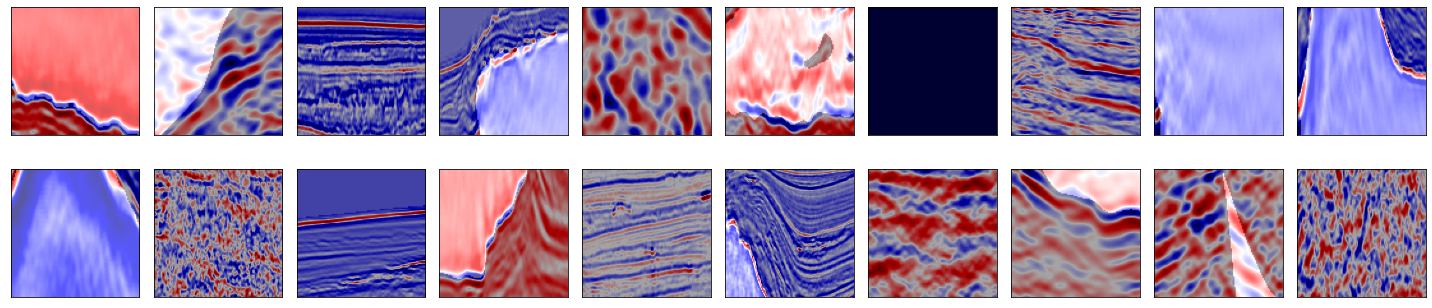

In [10]:
#check sample image
fig = plt.figure(figsize=(20, 5))

rand_idx = np.random.randint(0, 4000, 20) #generate random indexes

for i, file in enumerate(rand_idx):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    figs = df['id'][file]
    img = mpimg.imread(f'/kaggle/working/train/images/{figs}.png')
    mask = mpimg.imread(f'/kaggle/working/train/masks/{figs}.png')
    ax.imshow(img[:,:,0], cmap='seismic')
    ax.imshow(mask, alpha=0.35, cmap='gray')
    
plt.tight_layout()
plt.show()

## Constum Dataset

In [11]:
class Seismic(Dataset):
    def __init__(self, img_root, mask_root, X, transform=None):
        self.img_dir = img_root
        self.mask_dir = mask_root
        self.X = X
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        img_id = self.X[idx]
        
        img_path = self.img_dir + str(img_id) + ".png"
        mask_path = self.mask_dir + str(img_id) + ".png"
        
#         img = Image.open(img_path).resize((128, 128))
#         mask = Image.open(mask_path).resize((128, 128))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128,128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (128,128))
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask) #transform image and mask
            
            img = Image.fromarray(aug['image'])
            mask = Image.fromarray(aug['mask']).convert('L') #convert to 1channel
            
            t = T.ToTensor()
            img = t(img)
            mask = t(mask)
        
        if self.transform is None:
            img = Image.fromarray(img)
            mask = Image.fromarray(mask).convert('L')
            
            t = T.ToTensor()
            img = t(img)
            mask = t(mask)
        return img, mask

## Augmentation

## Split Data Train/Val/Test

In [12]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['id'].values, df['salt'].values,
                                                          stratify=df['salt'].values, 
                                                          test_size=0.05, random_state=97)

X_train, X_val = train_test_split(X_trainval, stratify=y_trainval, 
                                  test_size=0.1, random_state=97)

len(X_train), len(X_val), len(X_test)

(3420, 380, 200)

In [13]:
# img = cv2.imread(TRAIN_IMAGE_DIR+"f59821d067.png")
# mask = cv2.imread(TRAIN_MASK_DIR+"f59821d067.png")
# #aug = A.ElasticTransform()
# #img = cv2.resize(img, (128,128))
# trans = transform(image=img, mask=mask)
# plt.imshow(trans['image'], cmap='seismic')
# plt.imshow(trans['mask'], alpha=0.2, cmap='gray')

In [14]:
transform = A.Compose([A.HorizontalFlip(), 
                       A.VerticalFlip(),
                       A.RandomRotate90(), 
                       A.OpticalDistortion(),
                       A.Transpose()])

train_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_train, transform=transform)
val_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_val, transform)
test_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_test, transform=None)

In [15]:
# imge = Image.open(TRAIN_IMAGE_DIR+'351ea99ec3'+'.png')
# masks = Image.open(TRAIN_MASK_DIR+'351ea99ec3'+'.png')
# t = Compose([RandomRotate(30)])
# imgs, masks = t(imge, masks)
# # t = T.ToTensor()
# # img = t(imge)
# #mask /= 65535.
# imgs.max()

Image_size:  torch.Size([3, 128, 128])
Mask_size:  torch.Size([1, 128, 128])
Max Pixel Image Val: tensor(0.9059)
Max Pixel mask Val: tensor(1.)


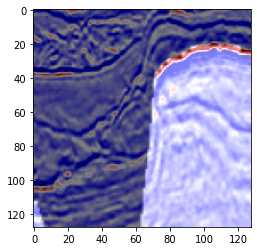

In [16]:
img, mask = test_set[21]
print("Image_size: ", img.size())
print("Mask_size: ", mask.size())
print('Max Pixel Image Val:', img.max())
print('Max Pixel mask Val:', mask.max())
plt.imshow(img[0], cmap='seismic')
plt.imshow(mask[0], alpha=0.5, cmap='gray');

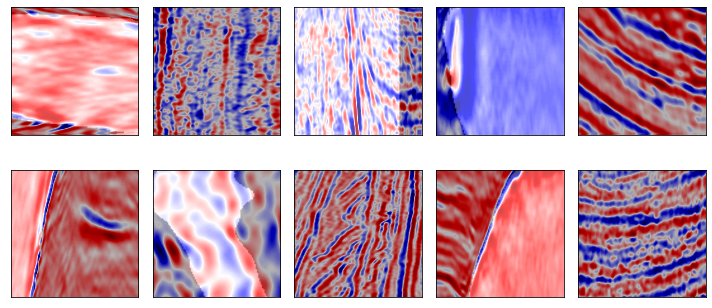

In [17]:
#check dataset with augmentation
fig = plt.figure(figsize=(10, 5))

rand_idx = np.random.randint(0, 3420, 10) #generate random indexes

for i, file in enumerate(rand_idx):
    image, mask = train_set[file]
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image[0], cmap='seismic')
    ax.imshow(mask[0], cmap='gray', alpha=0.3)

plt.tight_layout(); plt.show()

## Dataloader

In [31]:
#dataloader
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [34]:
def show_batch(dl):
    for images, mask in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0), cmap='seismic')
        ax.imshow(make_grid(mask, nrow=16).permute(1, 2, 0), alpha=0.5)
        break

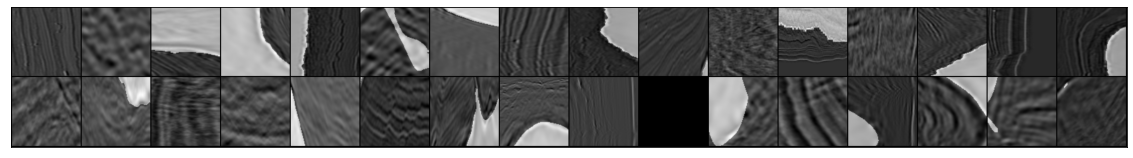

In [35]:
show_batch(train_loader)

# Model

## U-NET With Resnet18 Encoder from Scratch

In [36]:
class Decoder(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel):
        super(Decoder, self).__init__()
        
        self.conv = nn.Conv2d(in_channel, mid_channel, kernel_size=3, stride=1, padding=1) #keep ratio
        self.conv_trans = nn.ConvTranspose2d(mid_channel, out_channel, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv(x), inplace=True)
        x = F.relu(self.conv_trans(x), inplace=True)
        return x
    
class Unet_resnet18(nn.Module):
    def __init__(self, n_classes):
        super(Unet_resnet18, self).__init__()
        
        #encoder
        self.encoder = models.resnet18(pretrained=True)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1,
                                  self.encoder.relu, self.pool) #64
        self.conv2 = self.encoder.layer1 #64
        self.conv3 = self.encoder.layer2 #128
        self.conv4 = self.encoder.layer3 #256
        self.conv5 = self.encoder.layer4 #depth 512
        
        #center
        self.center = Decoder(512, 312, 256)
        
        #decoder
        self.decoder5 = Decoder(256+512, 256, 256)
        self.decoder4 = Decoder(256+256, 128, 128)
        self.decoder3 = Decoder(128+128, 64, 64)
        self.decoder2 = Decoder(64+64, 32, 32)
        self.decoder1 = Decoder(32, 16, 16)
        self.decoder0 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
    
        self.final = nn.Conv2d(8, n_classes, kernel_size=1)
        
    def forward(self, x):
        
        #encoder
        conv1 = self.conv1(x) #64x64
        conv2 = self.conv2(conv1) #32x32
        conv3 = self.conv3(conv2) #16x16
        conv4 = self.conv4(conv3) #8x8
        conv5 = self.conv5(conv4) #4x4
        
        center = self.center(self.pool(conv5)) #4x4
        #decoder
        dec5 = self.decoder5(torch.cat([center, conv5], 1)) #8x8
        dec4 = self.decoder4(torch.cat([dec5, conv4], 1)) #16x16
        dec3 = self.decoder3(torch.cat([dec4, conv3], 1)) #32x32
        dec2 = self.decoder2(torch.cat([dec3, conv2], 1)) #64x64
        dec1 = self.decoder1(dec2) #128x128
        dec0 = F.relu(self.decoder0(dec1))
        
        final = torch.sigmoid(self.final(dec0))
        
        return final
    
model_res18 = Unet_resnet18(1)
model_res18.to(device)
model_res18.train()
model_res18
#summary(test, (3, 128, 128) )

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Unet_resnet18(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Resnet34 (The Easy Way)

In [38]:
model_res34 = smp.Unet('resnet34', classes=1, activation='sigmoid')
model_res34.to(device)
model_res34.train()
model_res34

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Training
## Help Functions
### Costum Loss Functions

In [39]:
##loval loss :https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#PyTorch
class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        #inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz
    
##Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-5):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

### Costum Metrices

In [40]:
def accuracy(output, mask):
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    correct = top_class == mask.view(*top_class.shape)
    score = torch.mean(correct.type(torch.FloatTensor)).item()
    return score


def IoU_score(inputs, targets, smooth=1e-5):
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    #intersection is equivalent to True Positive count
    #union is the mutually inclusive area of all labels & predictions 
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 

    IoU = (intersection + smooth)/(union + smooth)
    
    return IoU

def Dice_score(inputs, targets, smooth=1e-5):
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
    
    return dice

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_dice = [];
    train_iou = []; train_dice = [];
    lrs = []
    
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        dice_score = 0
        #training loop
        for image, mask in train_loader:
            #training phase
            model.train()
            image = image.to(device); mask = mask.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            
            #score
            iou_score += IoU_score(output, mask).item()
            dice_score += Dice_score(output, mask).item()
            
            #backward
            loss.backward() 
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
        
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            total_train = 0
            correct_train = 0
            val_iou_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for image, mask in val_loader:
                    image = image.to(device); mask = mask.to(device);
                    output = model(image)
                    #score
                    val_iou_score +=  IoU_score(output, mask).item()
                    val_dice_score += Dice_score(output, mask).item()
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            #dice
            val_dice.append(val_dice_score/len(val_loader))
            train_dice.append(dice_score/len(train_loader))
        
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train IoU/Dice:{:.3f}/{:.3f}..".format((iou_score/len(train_loader)),(dice_score/len(train_loader))),
                  "Val IoU/Dice: {:.3f}/{:.3f}..".format((val_iou_score/len(val_loader)),(val_dice_score/len(val_loader))), 
                  "Time: {:.2f}s".format((time.time()-since)))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_dice':train_dice, 'val_dice': val_dice,
               'train_iou' :train_iou, 'val_iou':val_iou, 
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Training (Learning Time) 

## Resnet18

In [44]:
#model resnet18
model_res18 = Unet_resnet18(n_classes=1)
model_res18.to(device)
model_res18.train()

max_lr = 1e-3 #1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.BCELoss()
optimizer18 = torch.optim.AdamW(model_res18.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer18, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history18 = fit(epoch, model_res18, train_loader, val_loader, criterion, optimizer18, sched)

Epoch:1/20.. Train Loss: 0.643.. Val Loss: 0.463.. Train IoU/Dice:0.213/0.348.. Val IoU/Dice: 0.268/0.421.. Time: 14.68s
Epoch:2/20.. Train Loss: 0.450.. Val Loss: 0.460.. Train IoU/Dice:0.262/0.413.. Val IoU/Dice: 0.264/0.417.. Time: 13.89s
Epoch:3/20.. Train Loss: 0.395.. Val Loss: 0.375.. Train IoU/Dice:0.287/0.445.. Val IoU/Dice: 0.314/0.477.. Time: 13.90s
Epoch:4/20.. Train Loss: 0.352.. Val Loss: 0.291.. Train IoU/Dice:0.376/0.540.. Val IoU/Dice: 0.438/0.606.. Time: 13.66s
Epoch:5/20.. Train Loss: 0.288.. Val Loss: 0.364.. Train IoU/Dice:0.486/0.650.. Val IoU/Dice: 0.381/0.548.. Time: 14.20s
Epoch:6/20.. Train Loss: 0.286.. Val Loss: 0.349.. Train IoU/Dice:0.503/0.664.. Val IoU/Dice: 0.449/0.617.. Time: 13.99s
Epoch:7/20.. Train Loss: 0.263.. Val Loss: 0.310.. Train IoU/Dice:0.526/0.684.. Val IoU/Dice: 0.502/0.664.. Time: 13.77s
Epoch:8/20.. Train Loss: 0.231.. Val Loss: 0.224.. Train IoU/Dice:0.572/0.724.. Val IoU/Dice: 0.558/0.714.. Time: 13.87s
Epoch:9/20.. Train Loss: 0.217..

In [45]:
#using DiceLoss()
epoch = 20
max_lr = 1e-5 #1e-4

criterion_dice = DiceLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer18, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
history18_dice = fit(epoch, model_res18, train_loader, val_loader, 
                     criterion_dice, optimizer18, sched)

Epoch:1/20.. Train Loss: 0.136.. Val Loss: 0.136.. Train IoU/Dice:0.764/0.864.. Val IoU/Dice: 0.764/0.864.. Time: 14.17s
Epoch:2/20.. Train Loss: 0.127.. Val Loss: 0.125.. Train IoU/Dice:0.776/0.873.. Val IoU/Dice: 0.781/0.875.. Time: 14.10s
Epoch:3/20.. Train Loss: 0.127.. Val Loss: 0.120.. Train IoU/Dice:0.778/0.873.. Val IoU/Dice: 0.788/0.880.. Time: 13.95s
Epoch:4/20.. Train Loss: 0.112.. Val Loss: 0.103.. Train IoU/Dice:0.801/0.888.. Val IoU/Dice: 0.816/0.897.. Time: 13.93s
Epoch:5/20.. Train Loss: 0.106.. Val Loss: 0.097.. Train IoU/Dice:0.812/0.894.. Val IoU/Dice: 0.826/0.903.. Time: 14.11s
Epoch:6/20.. Train Loss: 0.102.. Val Loss: 0.103.. Train IoU/Dice:0.818/0.898.. Val IoU/Dice: 0.817/0.897.. Time: 14.13s
Epoch:7/20.. Train Loss: 0.099.. Val Loss: 0.103.. Train IoU/Dice:0.823/0.901.. Val IoU/Dice: 0.817/0.897.. Time: 14.03s
Epoch:8/20.. Train Loss: 0.096.. Val Loss: 0.111.. Train IoU/Dice:0.827/0.904.. Val IoU/Dice: 0.807/0.889.. Time: 13.82s
Epoch:9/20.. Train Loss: 0.094..

In [46]:
def combine_history(history18, history18_dice):
    t_loss = history18['train_loss'] + history18_dice['train_loss']
    v_loss = history18['val_loss'] + history18_dice['val_loss']
    t_dice = history18['train_dice'] + history18_dice['train_dice']
    v_dice = history18['val_dice'] + history18_dice['val_dice']
    t_iou = history18['train_iou'] + history18_dice['train_iou']
    v_iou = history18['val_iou'] + history18_dice['val_iou']
    lr = history18['lrs'] + history18_dice['lrs']
    comb = {'train_loss':t_loss, 'val_loss':v_loss, 'train_dice':t_dice,
            'val_dice':v_dice, 'train_iou':t_iou, 'val_iou':v_iou, 'lrs':lr}
    return comb

In [47]:
history_resnet18 = combine_history(history18, history18_dice)

In [ ]:
# epoch = 10
# max_lr = 1e-5 #1e-4

# criterion_lovasz = LovaszHingeLoss()
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer18, max_lr, epochs=epoch,
#                                             steps_per_epoch=len(train_loader))
# history18_lovasz = fit(epoch, model_res18, train_loader, val_loader, 
#                        criterion_lovasz, optimizer18, sched)

In [48]:
torch.save(model_res18.state_dict(), 'model_resnet18.pth')

## Resnet34

In [49]:
#model resnet34
model_res34 = smp.Unet('resnet34', classes=1, activation='sigmoid')
model_res34.to(device)
model_res34.train()

max_lr = 1e-3 #1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.BCELoss()
optimizer34 = torch.optim.AdamW(model_res34.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer34, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history34 = fit(epoch, model_res34, train_loader, val_loader, criterion, optimizer34, sched)

Epoch:1/20.. Train Loss: 0.763.. Val Loss: 0.552.. Train IoU/Dice:0.264/0.414.. Val IoU/Dice: 0.310/0.470.. Time: 17.29s
Epoch:2/20.. Train Loss: 0.472.. Val Loss: 0.408.. Train IoU/Dice:0.347/0.513.. Val IoU/Dice: 0.429/0.598.. Time: 17.17s
Epoch:3/20.. Train Loss: 0.323.. Val Loss: 0.293.. Train IoU/Dice:0.436/0.604.. Val IoU/Dice: 0.482/0.648.. Time: 17.43s
Epoch:4/20.. Train Loss: 0.290.. Val Loss: 0.470.. Train IoU/Dice:0.475/0.641.. Val IoU/Dice: 0.257/0.404.. Time: 17.53s
Epoch:5/20.. Train Loss: 0.283.. Val Loss: 0.441.. Train IoU/Dice:0.494/0.658.. Val IoU/Dice: 0.311/0.471.. Time: 17.36s
Epoch:6/20.. Train Loss: 0.273.. Val Loss: 0.225.. Train IoU/Dice:0.508/0.671.. Val IoU/Dice: 0.619/0.763.. Time: 17.04s
Epoch:7/20.. Train Loss: 0.255.. Val Loss: 0.436.. Train IoU/Dice:0.541/0.699.. Val IoU/Dice: 0.337/0.500.. Time: 17.84s
Epoch:8/20.. Train Loss: 0.246.. Val Loss: 0.306.. Train IoU/Dice:0.541/0.699.. Val IoU/Dice: 0.505/0.666.. Time: 17.15s
Epoch:9/20.. Train Loss: 0.234..

In [50]:
max_lr = 1e-5 #1e-4
epoch = 20

criterion_dice34 = DiceLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer34, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history34_dice = fit(epoch, model_res34, train_loader, val_loader, 
                criterion_dice34, optimizer34, sched)

Epoch:1/20.. Train Loss: 0.152.. Val Loss: 0.147.. Train IoU/Dice:0.738/0.848.. Val IoU/Dice: 0.747/0.853.. Time: 17.61s
Epoch:2/20.. Train Loss: 0.151.. Val Loss: 0.140.. Train IoU/Dice:0.740/0.849.. Val IoU/Dice: 0.755/0.860.. Time: 17.35s
Epoch:3/20.. Train Loss: 0.147.. Val Loss: 0.137.. Train IoU/Dice:0.745/0.853.. Val IoU/Dice: 0.761/0.863.. Time: 16.99s
Epoch:4/20.. Train Loss: 0.137.. Val Loss: 0.127.. Train IoU/Dice:0.762/0.863.. Val IoU/Dice: 0.777/0.873.. Time: 17.72s
Epoch:5/20.. Train Loss: 0.136.. Val Loss: 0.124.. Train IoU/Dice:0.764/0.864.. Val IoU/Dice: 0.782/0.876.. Time: 17.50s
Epoch:6/20.. Train Loss: 0.126.. Val Loss: 0.125.. Train IoU/Dice:0.779/0.874.. Val IoU/Dice: 0.782/0.875.. Time: 16.89s
Epoch:7/20.. Train Loss: 0.123.. Val Loss: 0.110.. Train IoU/Dice:0.783/0.877.. Val IoU/Dice: 0.806/0.890.. Time: 17.24s
Epoch:8/20.. Train Loss: 0.122.. Val Loss: 0.107.. Train IoU/Dice:0.786/0.878.. Val IoU/Dice: 0.810/0.893.. Time: 17.58s
Epoch:9/20.. Train Loss: 0.119..

In [51]:
history_resnet34 = combine_history(history34, history34_dice)

In [52]:
torch.save(model_res34.state_dict(), 'unet_resnet34.pth')

In [53]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(x, history):
    plt.plot(x, history['train_dice'], label='train_dice', marker='x')
    plt.plot(x, history['val_dice'], label='val_dice', marker='x')
    plt.plot(x, history['train_iou'], label='train_iou', marker='*')
    plt.plot(x, history['val_iou'], label='val_iou',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

RESNET18


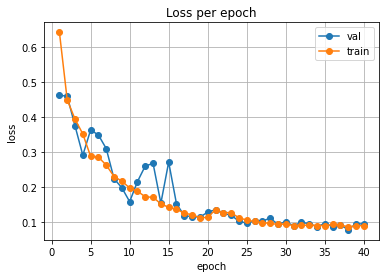

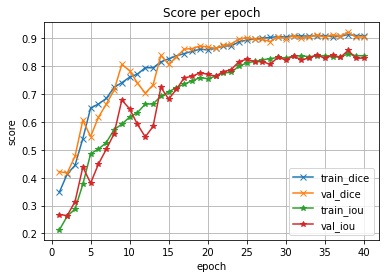

In [54]:
print('RESNET18')
plot_loss(np.arange(1,41), history_resnet18)
plot_score(np.arange(1,41), history_resnet18)

RESNET34


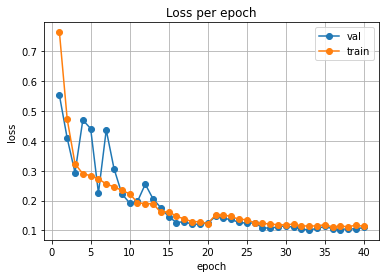

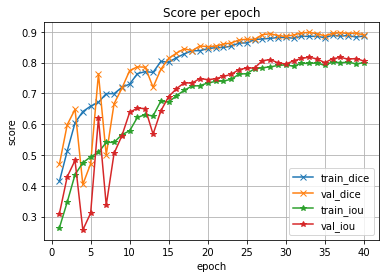

In [55]:
print('RESNET34')
plot_loss(np.arange(1,41), history_resnet34)
plot_score(np.arange(1,41), history_resnet34)

# Inference

In [56]:
def predict_image(model, image, mask, threshold):
    model.eval()
    with torch.no_grad():
        model.to(device)
        image = image.to(device)
        mask = mask.to(device)
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        predict = model(image) > threshold
        score = IoU_score(predict, mask)
        predict = predict.squeeze(0).squeeze(0)
    return predict.cpu(), score.item()

In [59]:
#load model state_dict()
unet_resnet18 = Unet_resnet18(n_classes=1)
unet_resnet18.load_state_dict(torch.load('model_resnet18.pth'))

unet_resnet34 = smp.Unet('resnet34', classes=1, activation='sigmoid')
unet_resnet34.load_state_dict(torch.load('unet_resnet34.pth'))

<All keys matched successfully>

## Finding Best Threshold

In [74]:
thre = np.linspace(0.4, 0.9, 15)
IoU_mean = []
for thres in thre:
    IoU = 0
    for image, mask in val_set:
        _, score = predict_image(unet_resnet18, image, mask, thres)
        IoU += score
    IoU_mean.append(IoU/len(val_set))

iou_score = pd.DataFrame({"Threshold": thre, "IoU_score": IoU_mean})
iou_score

,Threshold,IoU_score
0,0.400000,0.824230
1,0.435714,0.800011
2,0.471429,0.813455
3,0.507143,0.812592
4,0.542857,0.820733
5,0.578571,0.803337
6,0.614286,0.817847
7,0.650000,0.808210
8,0.685714,0.810914
9,0.721429,0.806183


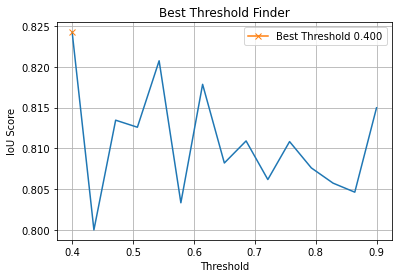

In [75]:
plt.plot(thre, IoU_mean)
plt.plot(thre[np.argmax(IoU_mean)], np.max(IoU_mean), marker='x',
        label='Best Threshold {:.3f}'.format(thre[np.argmax(IoU_mean)]))
plt.grid(); plt.ylabel('IoU Score'); plt.xlabel('Threshold');
plt.title('Best Threshold Finder')
plt.legend()
plt.show()

## Evaluation Using Test Set

In [76]:
score_all = []
for image, mask in test_set:
    _, score = predict_image(unet_resnet18, image, mask, threshold=0.5) #threshold can be different in datasets
    score_all.append(score)
print('IoU score over all test set Resnet18: ',np.mean(score_all))

IoU score over all test set Resnet18:  0.7714779843326482


In [77]:
score_all = []
for image, mask in test_set:
    _, score = predict_image(unet_resnet34, image, mask, threshold=0.5) #threshold can be different in datasets
    score_all.append(score)
print('IoU score over all test set Resnet34: ',np.mean(score_all))

IoU score over all test set Resnet34:  0.7804060719948817


In [101]:
#test single image
def plot_predict_image(idx):
    image, mask = test_set[idx]
    mask_pre, score = predict_image(unet_resnet34, image, mask, threshold=0.5)

    #plot
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[0], cmap='seismic')
    plt.contour(mask[0], cmap='Greens')
    plt.title('Seismic'); plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(mask_pre)
    plt.title('Predict Mask | score: {:.3f}'.format(score))
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(mask[0])
    plt.title('Ground truth')
    plt.axis('off');
    
    plt.subplot(1, 4, 4)
    plt.imshow(mask_pre, cmap='Greens')
    plt.imshow(mask[0], alpha=0.5)
    plt.title('Overlay Predict and Ground truth')
    plt.axis('off');

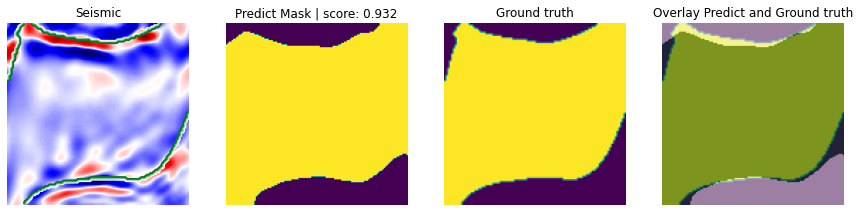

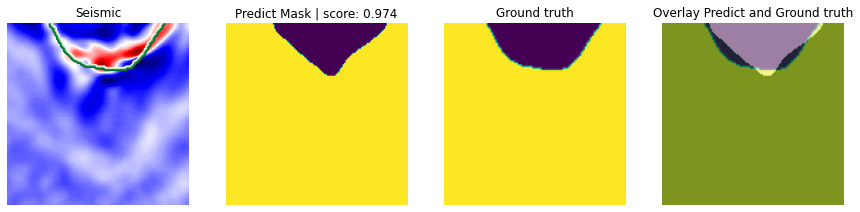

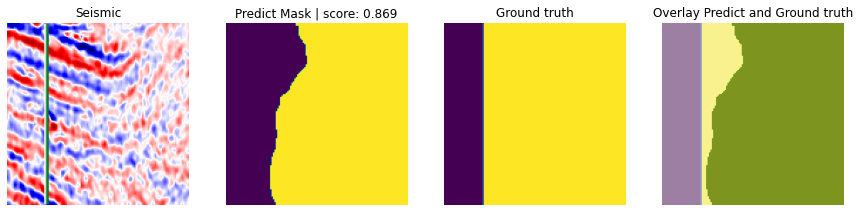

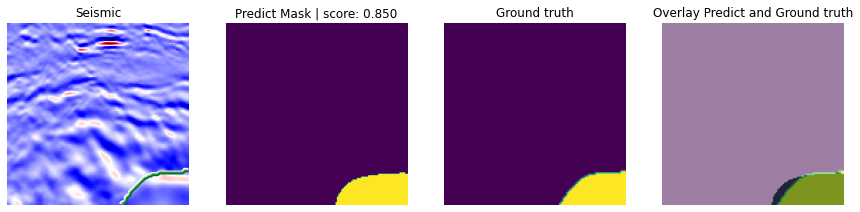

In [102]:
a = [159, 173, 53, 94]
for i in a:
    plot_predict_image(i)

In [ ]:
! pip install jovian
import jovian
jovian.commit(project= 'salt-segmentation', privacy='private')